# Facial Emotions Detection

In [1]:
import numpy as npy # linear algebra
import pandas as pds # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator as ImgDataGen
import os, sys, time, warnings, sklearn

In [2]:
ROOT='/kaggle/input'

In [3]:
TRAIN_PATH=ROOT+'/emotion-detection-fer/train'
TEST_PATH=ROOT+'/emotion-detection-fer/test'
train_angry_img_path=TRAIN_PATH +'/angry'

OVERSAMPLED_TRAIN_PATH='../fed_oversampled_train'
MODEL_PATH='models'
IMAGE_PATH='images'

# Model Architecture path
def model_arch(model_name):
    !mkdir images
    arch=IMAGE_PATH+'/fer-2013_'+model_name+'.png'
    return arch

#  TensorFlow Checkpoint save_weight uses .ckpt extension format
def checkpoint_path(model_name):
    checkpoint_path = MODEL_PATH+"/fedav_best_model-"+model_name+".ckpt"
    return checkpoint_path

## Exploratory Data Analysis


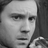

In [4]:
# Load a sample image 
# using open() to open images
image_data = Image.open(train_angry_img_path+'/im0.png')
image_data

Image shape: (48, 48)
Image data array: [[ 70  80  82 ...  52  43  41]
 [ 65  61  58 ...  56  52  44]
 [ 50  43  54 ...  49  56  47]
 ...
 [ 91  65  42 ...  72  56  43]
 [ 77  82  79 ... 105  70  46]
 [ 77  72  84 ... 106 109  82]]
Image array shape: (48, 48)


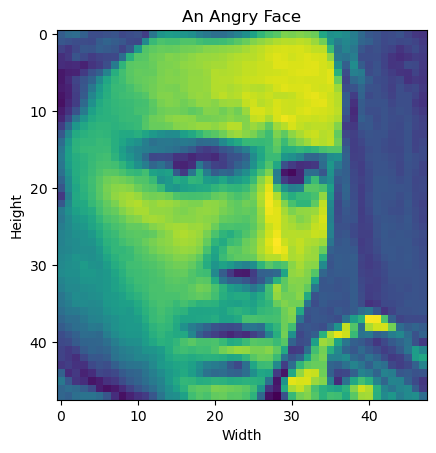

In [5]:
# Get the shape of the image
image=plt.imread(train_angry_img_path+'/im0.png')
print(f'Image shape: {image.shape}')

# Convert image data (like jpeg) to numpy using asarray()
image_array = npy.asarray(image_data)
print(f'Image data array: {image_array}')

# Get the shape of the image array
print(f'Image array shape: {image_array.shape}')

# Printing the image 
plt.imshow(image_array)
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('An Angry Face')
plt.show()

In [6]:
# Get the list of folders in the directory as classes
class_dir=os.listdir(TRAIN_PATH+'/')
class_dir

['fearful', 'disgusted', 'angry', 'neutral', 'sad', 'surprised', 'happy']

For Statistical Analysis, we'll load the images, convert them to numpy arrays, and store them in a pandas dataframe with the columns 'filename', 'image', and 'label'

In [7]:
# set up file paths and labels
folder_names = class_dir
label_dict = {folder_names[i]:i for i in range(len(folder_names))}
image_filenames = []
labels = []

# iterate through each folder and collect filenames and labels
for folder_name in folder_names:
    folder_path = os.path.join(TRAIN_PATH, folder_name)
    for filename in os.listdir(folder_path):
        if filename.endswith('.png'):
            image_filenames.append(os.path.join(folder_name, filename))
            labels.append(label_dict[folder_name])

# create pandas dataframe
df = pds.DataFrame({'filename': image_filenames, 'emotion': labels})

dfcopy = df.copy()

# Export the preprocessed file to CSV
!mkdir -p output
df.to_csv('output/fer-2013-images_preprocessed.csv', index=False)

# display dataframe
df

,filename,emotion
0,fearful/im1375.png,0
1,fearful/im3465.png,0
2,fearful/im3209.png,0
3,fearful/im1444.png,0
4,fearful/im1029.png,0
...,...,...
28704,happy/im6327.png,6
28705,happy/im5849.png,6
28706,happy/im506.png,6
28707,happy/im4034.png,6


In [8]:
def class_sample(type):
    if type.lower() == 'test' or type.lower() == 'train':
        path=''
        if type.lower() == 'train':    
            path= TRAIN_PATH
        else:
            path= TEST_PATH
        
        filepath=path+'/'
        class_count = []
        class_dict ={}
        for folder in os.listdir(filepath) :
              class_count.append(len(os.listdir(filepath+folder)))
              class_dict[folder]=len(os.listdir(filepath+folder))
        class_total = sum(class_count)
        return class_total, class_count, class_dict
    else:
        raise ValueError('Invalid type. Must be "test" or "train".')


def test_train_distribution():
      print("---- Train Set ----")
      avg_train=class_sample('train')[0]/len(class_sample('train')[1])
      print(f'Train class distribution:\n{class_sample("train")[2]}')
      print("Average train class: ",round(avg_train))    
      print('Total train: ', class_sample('train')[0])

      print("\n---- Test Set ----")
      avg_test=class_sample('test')[0]/len(class_sample('test')[1])
      print(f'Test class distribution:\n{class_sample("test")[2]}')
      print("Average test class: ",round(avg_test)) 
      print('Total test: ', class_sample('test')[0])


test_train_distribution()

---- Train Set ----
Train class distribution:
{'fearful': 4097, 'disgusted': 436, 'angry': 3995, 'neutral': 4965, 'sad': 4830, 'surprised': 3171, 'happy': 7215}
Average train class:  4101
Total train:  28709

---- Test Set ----
Test class distribution:
{'fearful': 1024, 'disgusted': 111, 'angry': 958, 'neutral': 1233, 'sad': 1247, 'surprised': 831, 'happy': 1774}
Average test class:  1025
Total test:  7178


## Data Visualization 

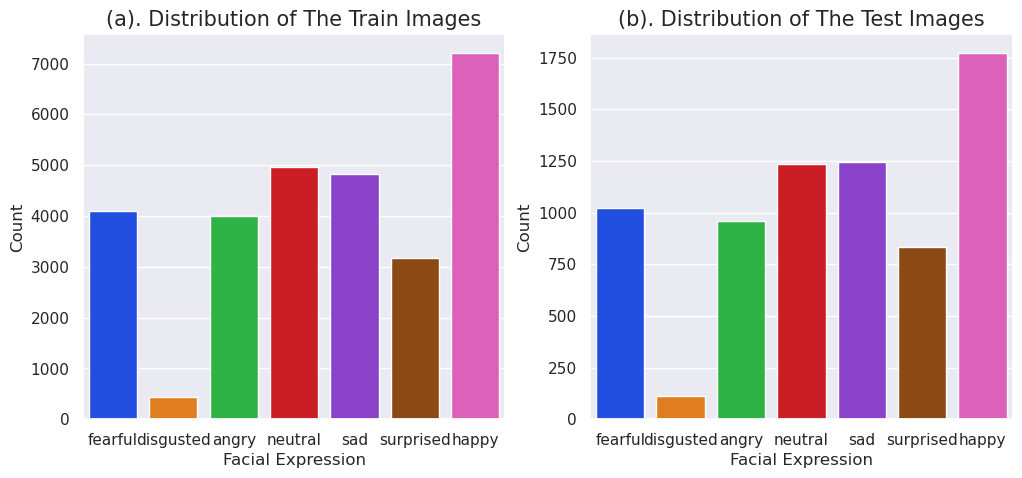

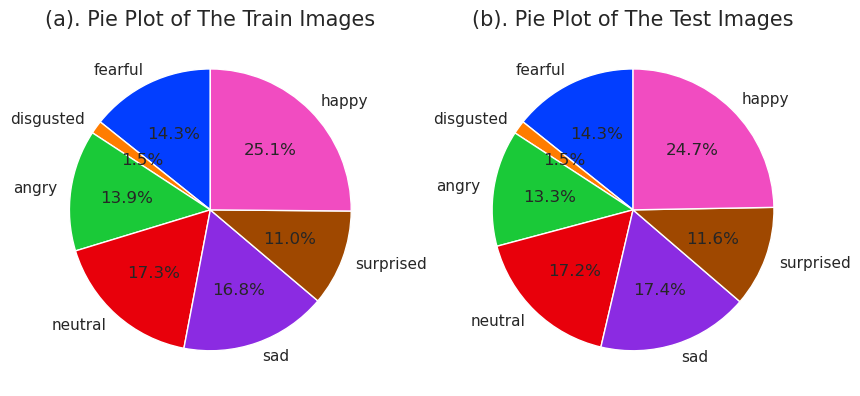

In [9]:
df_train = pds.DataFrame(list(class_sample("train")[2].items()), columns=['Emotion', 'Count'])
df_train.index.name = 'Emotion'
df_test = pds.DataFrame(list(class_sample("test")[2].items()), columns=['Emotion', 'Count'])
df_test.index.name = 'Emotion'


# plot a barplot with vertical orientation
sns.set()
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
axis = sns.barplot(x='Emotion', y='Count', data=df_train, orient='v', palette='bright')
# set labels and title
plt.xlabel("Facial Expression", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("(a). Distribution of The Train Images", fontsize=15)
# plt.legend( df_train.Emotion, loc='upper left')
# set x-axis tick labels
# axis.set_xticks(range(len(df_train.Emotion)), df_train.Emotion)
# axis.yaxis.set_major_locator(ticker.MultipleLocator(2.5))

plt.subplot(1, 2, 2)
sns.barplot(x='Emotion', y='Count', data=df_test, orient='v', palette='bright')
plt.xlabel("Facial Expression", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("(b). Distribution of The Test Images", fontsize=15)
plt.show()

print('\n\n')

x_train = npy.array([ len(os.listdir(TRAIN_PATH+'/'+class_name+'/')) for class_name in class_dir])
x_test = npy.array([ len(os.listdir(TEST_PATH+'/'+class_name+'/')) for class_name in class_dir])
label = class_dir
  
# plot a Pie plot with vertical orientation
plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
# define Seaborn color palette to use
palette_color = sns.color_palette('bright')
plt.pie(x_train, labels=label, colors=palette_color, autopct='%1.1f%%', startangle=90)
ax.set_title('(a). Pie Plot of The Train Images', fontsize=15)

ay = plt.subplot(1, 2, 2)
plt.pie(x_test, labels=label, colors=palette_color, autopct='%1.1f%%', startangle=90)
ay.set_title('(b). Pie Plot of The Test Images', fontsize=15)
plt.show()


## Data pre-processing

### Oversampling

In [10]:
# Oversampling Technique
import os
from PIL import Image

# Define the paths to the original and oversampled dataset
train_dir = TRAIN_PATH
oversampled_dir = OVERSAMPLED_TRAIN_PATH

target_length = 7215 # Using the highest count 
# target_length = 4101 # Using the average 

if not os.path.exists(oversampled_dir):
    os.mkdir(oversampled_dir)

for subfolder in os.listdir(train_dir):
    subfolder_path = os.path.join(train_dir, subfolder)
    if os.path.isdir(subfolder_path):
        num_images = len(os.listdir(subfolder_path))
        num_duplicates = target_length // num_images
        remainder = target_length % num_images

        for i in range(num_duplicates):
            for image_file in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, image_file)
                image = Image.open(image_path)
                new_image_file = f"{i}_{image_file}"
                new_image_path = os.path.join(oversampled_dir, subfolder, new_image_file)
                if not os.path.exists(os.path.join(oversampled_dir, subfolder)):
                    os.mkdir(os.path.join(oversampled_dir, subfolder))
                image.save(new_image_path)

        if remainder != 0:
            for image_file in os.listdir(subfolder_path)[:remainder]:
                image_path = os.path.join(subfolder_path, image_file)
                image = Image.open(image_path)
                new_image_file = f"{num_duplicates}_{image_file}"
                new_image_path = os.path.join(oversampled_dir, subfolder, new_image_file)
                if not os.path.exists(os.path.join(oversampled_dir, subfolder)):
                    os.mkdir(os.path.join(oversampled_dir, subfolder))
                image.save(new_image_path)

In [11]:
def over_class_sample():
        filepath=OVERSAMPLED_TRAIN_PATH+'/'
        class_count = []
        class_dict ={}
        for folder in os.listdir(filepath) :
              class_count.append(len(os.listdir(filepath+folder)))
              class_dict[folder]=len(os.listdir(filepath+folder))
        class_total = sum(class_count)
        return class_total, class_count, class_dict


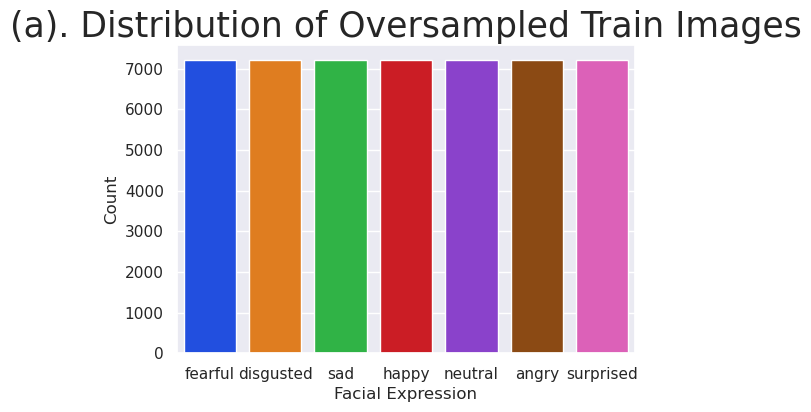


---- Oversampled Train Set ----
Train class distribution:
{'fearful': 7215, 'disgusted': 7215, 'sad': 7215, 'happy': 7215, 'neutral': 7215, 'angry': 7215, 'surprised': 7215}
Average train class:  7215
Total train:  50505


In [12]:
df_overtrain = pds.DataFrame(list(over_class_sample()[2].items()), columns=['Emotion', 'Count'])
df_overtrain.index.name = 'Emotion'


# plot a barplot with vertical orientation
sns.set()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
axis = sns.barplot(x='Emotion', y='Count', data=df_overtrain, orient='v', palette='bright')
# set labels and title
plt.xlabel("Facial Expression", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("(a). Distribution of Oversampled Train Images", fontsize=25)
plt.show()

def test_train_distribution():
      print("\n---- Oversampled Train Set ----")
      avg_train=over_class_sample()[0]/len(over_class_sample()[1])
      print(f'Train class distribution:\n{over_class_sample()[2]}')
      print("Average train class: ",round(avg_train))    
      print('Total train: ', over_class_sample()[0])



test_train_distribution()

## Data Augmentation

In [13]:
#Definnig a function to do so 
def grayscale_RGB_and_upsizing(image,size=[224,224]):
    # image = tf.image.grayscale_to_rgb(tf.convert_to_tensor(image))
    image = tf.image.resize(tf.convert_to_tensor(image), size)
    return image

In [14]:
target_size=(48, 48)
# target_size=(224, 224)
batch_size=32

## Train Image Data Generator instance. 
# We will not apply any transformon specific orientations or features and no initial rescale to the image
# We'll only split the image data into train and validation set
trainValidation_data_generator = ImgDataGen(
                                            # rescale=1./225,
                                            rotation_range=10,  # Randomly rotate images by up to 10 degrees
                                            zoom_range=0.2,  # Randomly zoom images by up to 20%
                                            width_shift_range=0.1,  # Randomly shift images horizontally by up to 10% of the image width
                                            height_shift_range=0.1,  # Randomly shift images vertically by up to 10% of the image height
                                            shear_range=0.2,  # Randomly apply shearing transformations
                                            horizontal_flip=True,  # Randomly flip images horizontally
                                            fill_mode='nearest',  # Fill in missing pixels with the nearest value
                                            # preprocessing_function=grayscale_RGB_and_upsizing,
                                            validation_split=0.2    # set the validation split                                
                                            )

# Test Image Data Generator instance for Test data
validation_data_generator = ImgDataGen(
                                    validation_split=0.14,
                                    )

# Test Image Data Generator instance for Test data
test_data_generator = ImgDataGen(
                                # rescale = 1./255,
                                )

# Set a random seed to synchronize the shuffle order across different runs of the generator
# trainValidation_data_generator.set_seed(42)

## Create Train, Validation, and Test Generators 

In [15]:
# Successfully mapped the train-images to their classes from the dataframe. Now let's do the same for the test-images. 
# Here, I will only be rescaling. No other transformations are applies, to preserve originality of the images.

classes = ['angry', 'fearful', 'surprised', 'sad']

## Mapping images to their classes.
print('Train Set Generated - ',end=' ') 
train_generator = trainValidation_data_generator.flow_from_directory(
                                                            directory=OVERSAMPLED_TRAIN_PATH, 
                                                            # directory=TRAIN_PATH, 
                                                            target_size=target_size,
                                                            batch_size=batch_size,
                                                            class_mode='categorical', 
                                                            color_mode='rgb', 
                                                            classes=classes,
                                                            shuffle=True, 
                                                            subset='training' # set as training data
                                                        )
## Mapping images to their classes.
print('Validation Set Generated - ',end=' ') 
validation_generator = trainValidation_data_generator.flow_from_directory(
                                                            # directory=TRAIN_PATH, 
                                                            directory=OVERSAMPLED_TRAIN_PATH, 
                                                            target_size=target_size,
                                                            batch_size=batch_size,
                                                            class_mode='categorical', 
                                                            color_mode='rgb', 
                                                            classes= classes,
                                                            shuffle=False, 
                                                            subset='validation' # set as validation data
                                                        )
test_samples=class_sample('test')[0]
test_batch_size=batch_size
test_steps=int(test_samples/test_batch_size)

## Mapping images to their classes.
print('Test Set Generated - ',end=' ') 
test_generator = test_data_generator.flow_from_directory(
                                        directory=TEST_PATH, 
                                        target_size=target_size,
                                        class_mode='categorical', 
                                        color_mode='rgb', 
                                        classes=classes,
                                        shuffle=False, 
                                        batch_size=test_batch_size
                                        )

## Mapping shuffled images to their classes.
print('Shuffled Test Set Generated - ',end=' ') 
test_generator_shuffled = test_data_generator.flow_from_directory(
                                        TEST_PATH, 
                                        target_size=target_size,
                                        class_mode='categorical', 
                                        color_mode='rgb', 
                                        classes=classes,
                                        shuffle=True, 
                                        batch_size=test_batch_size
                                        )

Train Set Generated -  Found 23088 images belonging to 4 classes.
Validation Set Generated -  Found 5772 images belonging to 4 classes.
Test Set Generated -  Found 4060 images belonging to 4 classes.
Shuffled Test Set Generated -  Found 4060 images belonging to 4 classes.


### Visualization

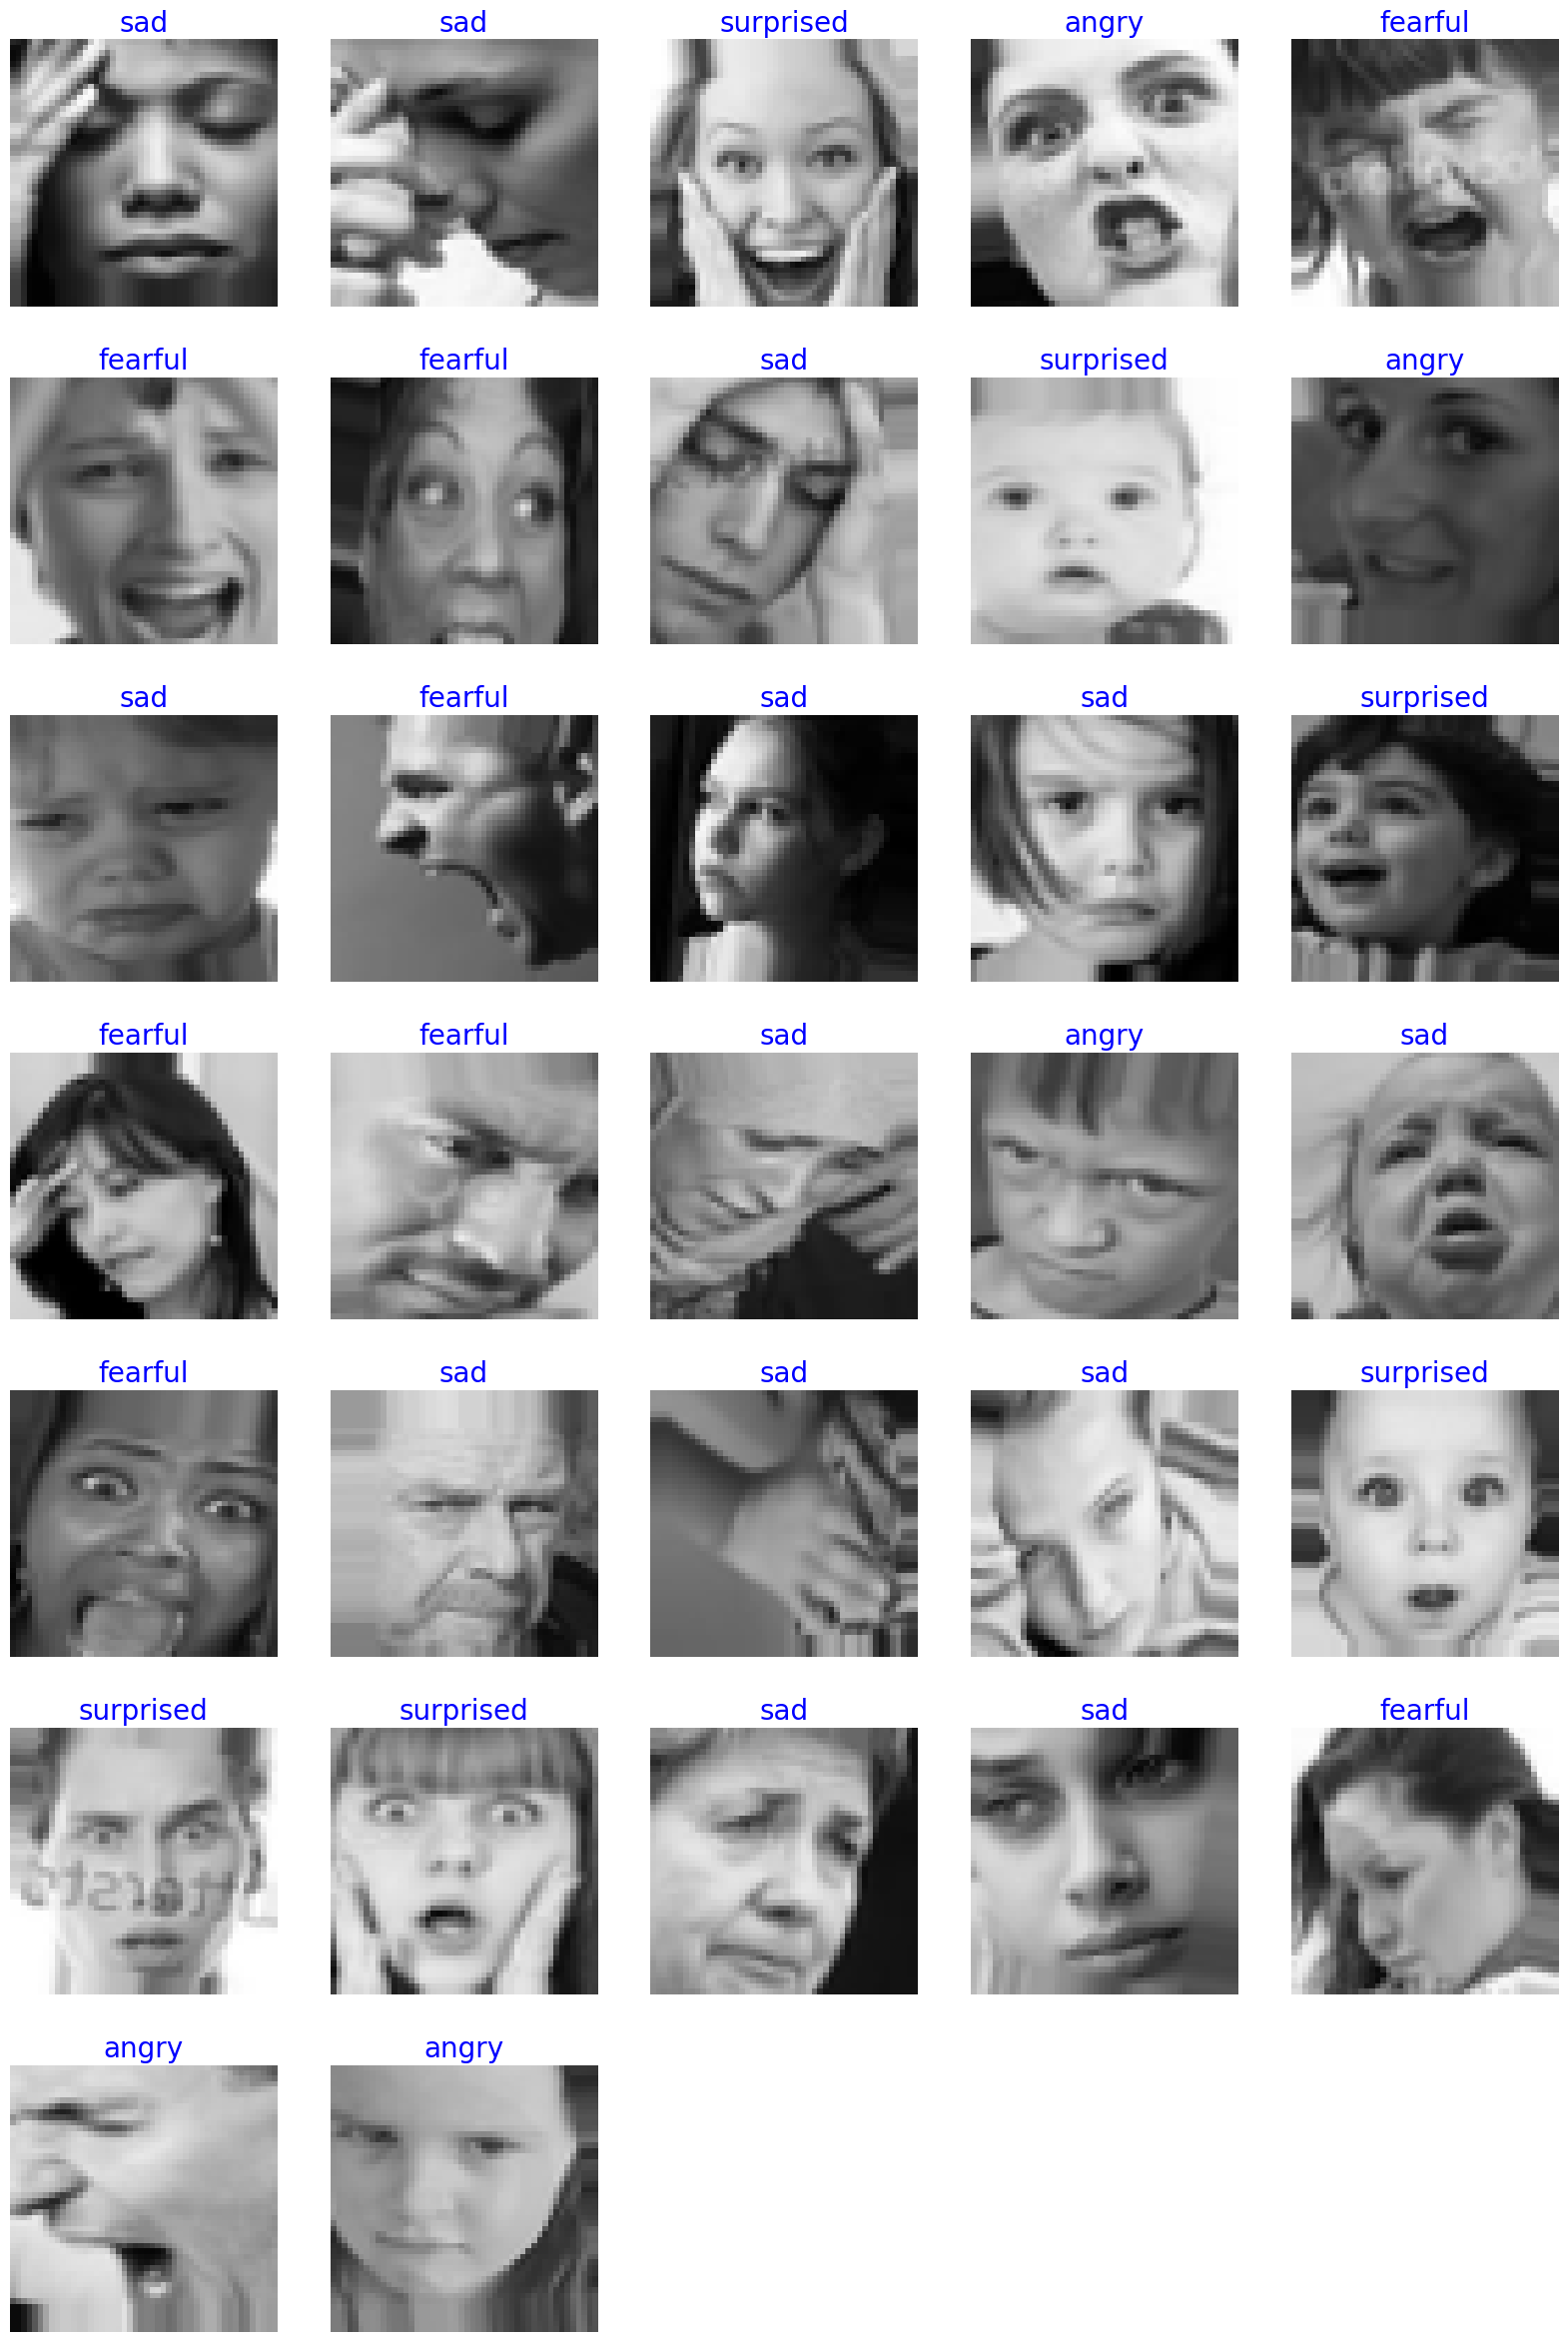

In [16]:
# Get the sample images, labels, and their filenames 
# To get the correct filename, turn off the shuffle
def plotImageWithNames(gen):
    images, labels = next(gen)
    filenames = gen.filenames
    classes = list(gen.class_indices.keys())
    
    plt.figure(figsize=(20, 30))
    length=len(labels)
    if length<32:  
        r=length
    else:
        r=32
    for i in range(r):        
        plt.subplot(7, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=npy.argmax(labels[i])
        class_name=classes[index]
        filename=gen.filenames[i]
        plt.title(
                    label=f"{class_name}", # \n{filename} ", 
                    color='blue', 
                    fontsize=20
                    )
        plt.axis('off')
    plt.show()

plotImageWithNames(train_generator)

## Model Development

In [17]:
from tensorflow import keras
from sklearn import set_config
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator as ImgDataGen
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.models import Sequential, load_model

from tensorflow.keras import layers, optimizers, metrics, regularizers, models
from tensorflow.keras.optimizers import Adam, Adamax

In [18]:
input_shape=(target_size[0], target_size[1], 3)
batch_size = batch_size
epochs=60
ask_epoch=0

## Model Building and Compiling

In [19]:
class_keys = list(train_generator.class_indices.keys())
class_count = len(class_keys)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Model
model_name='EfficientNetB3'
base_model=tf.keras.applications.efficientnet.EfficientNetB3(
                                                            include_top=False, 
                                                            weights="imagenet",
                                                            input_shape=input_shape, 
                                                            pooling='max'
                                                            ) 

# Let's make our base_model trainable to get better results
base_model.trainable=True
x=base_model.output

x=BatchNormalization(
                    axis=-1, 
                    momentum=0.99, 
                    epsilon=0.001,
                    name='batch_norm_x' 
                    )(x)
x = Dense(
          256, 
          kernel_regularizer = regularizers.l2(l = 0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006),
          activation='relu',
          name='dense_x'
          )(x)

x=Dropout(
          rate=.4, 
          seed=123,
          name='dropout_x'
          )(x) 
      
output=Dense(
            class_count, 
            activation='softmax',
            name='dense_output'
            )(x)
cnn_model=Model(inputs=base_model.input, outputs=output, name=model_name)
learning_rate=.001 # start with this learning rate
cnn_model.compile(
                  Adamax(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy']
                  )

# View the model summary
cnn_model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "EfficientNetB3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 48, 48, 3)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 48, 48, 3)    7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 48, 48, 3)    0           ['normalization[0][0]']          
                    

## Create a Custom Keras Callback to Continue or Halt Training

In [21]:
# starting the Checkpoint for the model
# checkpoint_dir = os.path.dirname(checkpoint_path)

check_point = tf.keras.callbacks.ModelCheckpoint(
                                          filepath=checkpoint_path(model_name),
                                          save_weights_only=True,
                                          save_best_only=True, 
                                          monitor="val_accuracy",
                                          verbose = 1,
                                        )

reduce_learning = tf.keras.callbacks.ReduceLROnPlateau(
                                            monitor="val_accuracy", 
                                            # factor=0.5, 
                                            patience=2,
                                            verbose=1
                                            )

early_stop = tf.keras.callbacks.EarlyStopping(
                                       monitor="val_accuracy", 
                                       min_delta=0.0005,
                                       patience=11, 
                                       verbose=1,
                                       restore_best_weights=True
                                       )

callbacks = [
            check_point,
            reduce_learning, 
            early_stop, 
          ]

## Model Training

In [ ]:
model_history=cnn_model.fit(
                  train_generator,  
                  steps_per_epoch=train_generator.n//train_generator.batch_size,
                  epochs=epochs, 
                  verbose=1, 
                  callbacks=callbacks,  
                  validation_data=validation_generator,
                #   validation_steps=None, 
                  validation_steps= validation_generator.n//validation_generator.batch_size,
                  )

Epoch 1/60


2023-05-28 08:24:59.407767: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetB3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


721/721 [==============================] - ETA: 0s - loss: 5.2666 - accuracy: 0.3848
Epoch 1: val_accuracy improved from -inf to 0.45642, saving model to models/fedav_best_model-EfficientNetB3.ckpt
721/721 [==============================] - 179s 137ms/step - loss: 5.2666 - accuracy: 0.3848 - val_loss: 2.7312 - val_accuracy: 0.4564 - lr: 0.0010
Epoch 2/60
721/721 [==============================] - ETA: 0s - loss: 1.9408 - accuracy: 0.4670
Epoch 2: val_accuracy improved from 0.45642 to 0.53194, saving model to models/fedav_best_model-EfficientNetB3.ckpt
721/721 [==============================] - 96s 133ms/step - loss: 1.9408 - accuracy: 0.4670 - val_loss: 1.4135 - val_accuracy: 0.5319 - lr: 0.0010
Epoch 3/60
721/721 [==============================] - ETA: 0s - loss: 1.2824 - accuracy: 0.5288
Epoch 3: val_accuracy improved from 0.53194 to 0.57622, saving model to models/fedav_best_model-EfficientNetB3.ckpt
721/721 [==============================] - 94s 130ms/step - loss: 1.2824 - accuracy

In [38]:
cnn_model.load_weights('models/fedav_best_model-EfficientNetB3.ckpt')

In [41]:
model_history=cnn_model.fit(
                  train_generator,  
                  steps_per_epoch=train_generator.n//train_generator.batch_size,
                  epochs=epochs, 
                  verbose=1, 
                  callbacks=callbacks,  
                  validation_data=validation_generator,
                #   validation_steps=None, 
                  validation_steps= validation_generator.n//validation_generator.batch_size,
                  )

Epoch 1/60


2023-05-28 16:53:35.166186: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetB3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


721/721 [==============================] - ETA: 0s - loss: 0.2341 - accuracy: 0.9390
Epoch 1: val_accuracy improved from -inf to 0.87483, saving model to models/fedav_best_model-EfficientNetB3.ckpt
721/721 [==============================] - 176s 135ms/step - loss: 0.2341 - accuracy: 0.9390 - val_loss: 0.4543 - val_accuracy: 0.8748 - lr: 1.0000e-04
Epoch 2/60
721/721 [==============================] - ETA: 0s - loss: 0.2330 - accuracy: 0.9400
Epoch 2: val_accuracy did not improve from 0.87483
721/721 [==============================] - 90s 125ms/step - loss: 0.2330 - accuracy: 0.9400 - val_loss: 0.4562 - val_accuracy: 0.8720 - lr: 1.0000e-04
Epoch 3/60
721/721 [==============================] - ETA: 0s - loss: 0.2212 - accuracy: 0.9446
Epoch 3: val_accuracy did not improve from 0.87483

Epoch 3: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
721/721 [==============================] - 90s 124ms/step - loss: 0.2212 - accuracy: 0.9446 - val_loss: 0.4527 - val_accuracy: 

KeyboardInterrupt: 

## Evaluate the model


In [42]:
loss, acc = cnn_model.evaluate(validation_generator, verbose=2)
print("Restored model, validation accuracy: {:5.2f}%".format(100 * acc))

181/181 - 9s - loss: 0.4280 - accuracy: 0.8844 - 9s/epoch - 52ms/step
Restored model, validation accuracy: 88.44%


## Prediction on Test Images 

In [43]:


# 
def ModelPredictionOnTestDataset(test_generator=test_generator):
#     test_steps= test_generator.n//test_generator.batch_size
    y_pred= []
    y_label=test_generator.labels
    classes=list(train_generator.class_indices.keys())
    class_count=len(classes)
    wrong_predictions=0
    
    # predict on the test set
    preds=cnn_model.predict(test_generator, test_steps, verbose=1) 
    
    total_predictions=len(preds)
    print(f'total prediction: {total_predictions}')
    for i, p in enumerate(preds):
            pred_index=npy.argmax(p)  
            # labels are integer values       
            true_index=test_generator.labels[i]  
            if pred_index != true_index:       
                # a misclassification has occurred                                     
                wrong_predictions=wrong_predictions + 1
            y_pred.append(pred_index)
    acc=( 1-wrong_predictions/total_predictions) * 100
    print(f'\n{wrong_predictions} out of {total_predictions} tested images could not be detected properly.\nAccuracy of {acc:6.2f}\n')
    ypred=npy.array(y_pred)
    ytrue=npy.array(y_label)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(8, 4))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(npy.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(npy.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix on Validation Data", fontsize=40)
        plt.show()
    clr = classification_report(y_label, y_pred, target_names=classes, digits= 5) # create classification report
    print("Classification Report on Validation Data:\n-------------------------------------\n", clr)

#     # Plot the confusion matrix
#         ConfusionMatrix(
#                         label_test=ytrue, 
#                         label_prep=ypred, 
#                         class_count=class_count, 
#                         class_keys=class_keys, 
#                         heada=' for Entire Test Set'
#                         )
        
    return wrong_predictions, total_predictions


181/181 [==============================] - 12s 56ms/step
total prediction: 5772

694 out of 5772 tested images could not be detected properly.
Accuracy of  87.98



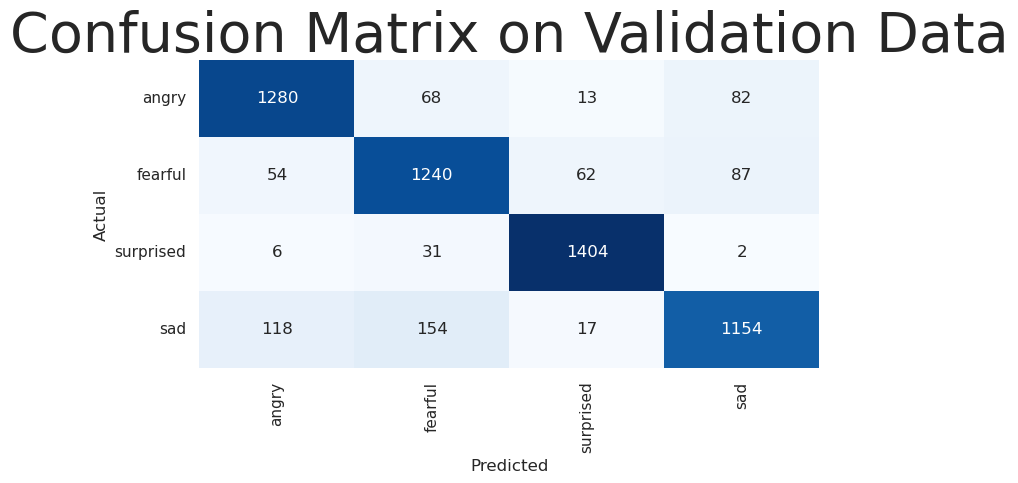

Classification Report on Validation Data:
-------------------------------------
               precision    recall  f1-score   support

       angry    0.87791   0.88704   0.88245      1443
     fearful    0.83054   0.85932   0.84469      1443
   surprised    0.93850   0.97297   0.95543      1443
         sad    0.87094   0.79972   0.83382      1443

    accuracy                        0.87976      5772
   macro avg    0.87948   0.87976   0.87910      5772
weighted avg    0.87948   0.87976   0.87910      5772



In [44]:
# Validation
wrong_predictions, total_predictions = ModelPredictionOnTestDataset(validation_generator)

127/127 [==============================] - 29s 227ms/step
total prediction: 4060

1393 out of 4060 tested images could not be detected properly.
Accuracy of  65.69



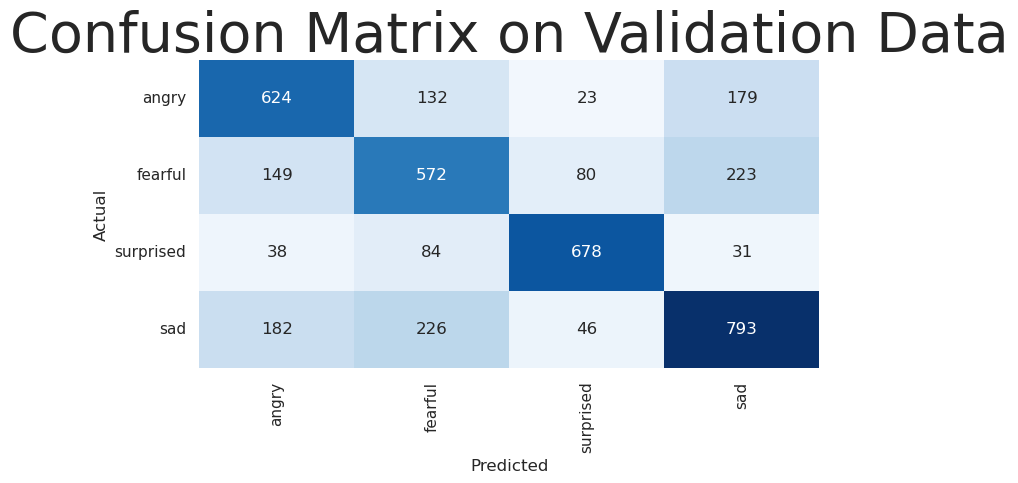

Classification Report on Validation Data:
-------------------------------------
               precision    recall  f1-score   support

       angry    0.62840   0.65136   0.63967       958
     fearful    0.56410   0.55859   0.56133      1024
   surprised    0.81983   0.81588   0.81785       831
         sad    0.64682   0.63593   0.64133      1247

    accuracy                        0.65690      4060
   macro avg    0.66479   0.66544   0.66505      4060
weighted avg    0.65702   0.65690   0.65689      4060



(1393, 4060)

In [45]:
# test dataset
ModelPredictionOnTestDataset()

In [46]:
!7z a emotion-detection-model-weights.zip models/
# cnn_model.save('output.h5')


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive:
  0M Sca        1 folder, 3 files, 133729119 bytes (128 MiB)

Creating archive: emotion-detection-model-weights.zip

Items to compress: 4

      2% 3 + models/fedav_best_model-EfficientNetB3.ckpt.ind                                                          5% 3 + models/fedav_best_model-EfficientNetB3.ckpt.ind                                                          7% 3 + models/fedav_best_model-EfficientNetB3.ckpt.ind                                                         10% 3 + models/fedav_best_model-EfficientNetB3.ckpt.ind                                                         12% 3 + models/fedav_best_model-EfficientNetB3.ckpt.ind                                                         15% 3 + models/fedav_best_model-EfficientNetB3.ckpt.ind                           

1/1 [==============================] - 3s 3s/step
correct prediction: 0.65625 



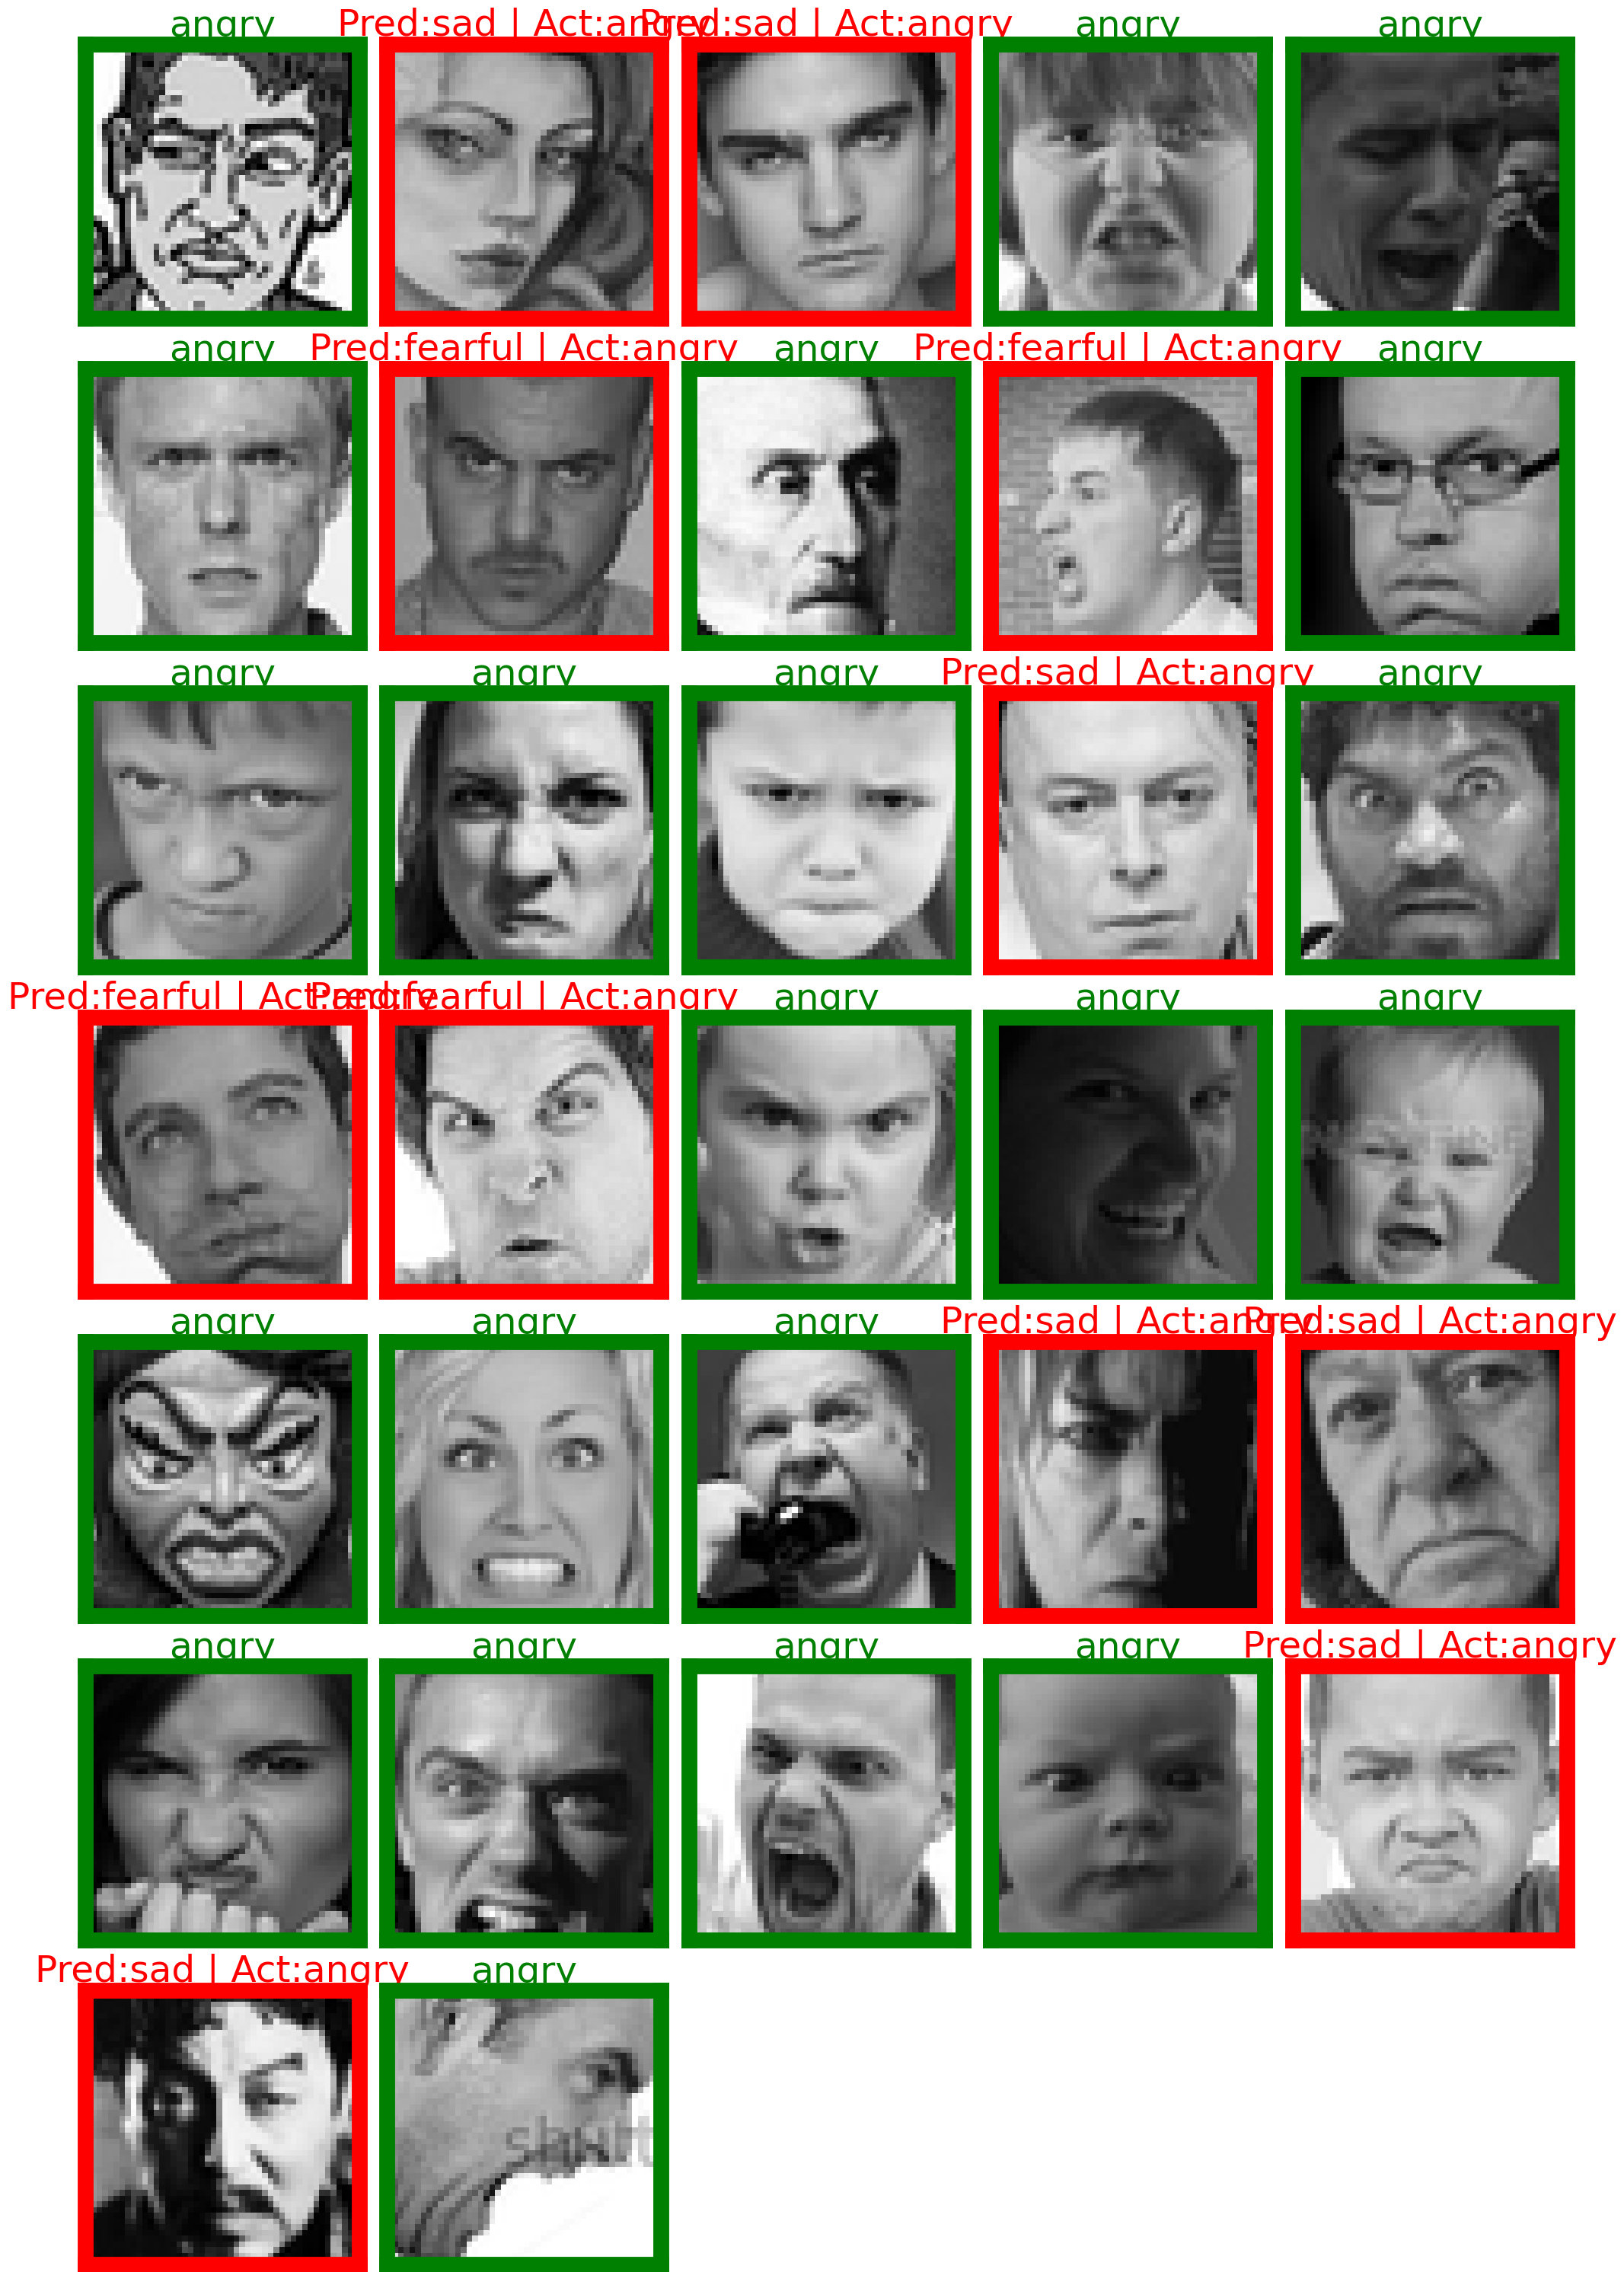

In [47]:
test_images, test_labels = next(test_generator)
preds = cnn_model.predict(test_images)
# One hot conversion
label_prep = npy.argmax(preds, axis = 1)
label_test = npy.argmax(test_labels, axis = 1)
# Reshape
label_prep = label_prep.reshape((-1, 1))
label_test = npy.reshape(label_test, (len(label_test), 1))

print('correct prediction:', npy.sum((label_test == label_prep)*1)/test_batch_size,'\n')


def compare(label_prep, gen=train_generator):
    class_dictionary = gen.class_indices
    for key, value in class_dictionary.items():
        if value == label_prep:
             return key

def dif(label_test, label_prep, gen=train_generator):    
    class_dictionary = gen.class_indices
    test = ''
    id = ''
    for key, value in class_dictionary.items():
        if value == label_test:
            test = key
        if value == label_prep:
            id = key
    return test, id

#Code by Hitesh Kumar https://www.kaggle.com/hitzz97/emotion-detection

fig = plt.figure(figsize=((20, 30)))

# k = 0
for j in range(len(label_prep)):
    ax = plt.subplot(7, 5, j+1)
    px = test_images[j]/255
#     k += 1
    ax.imshow(px)
    ax.set_xticks([])
    ax.set_yticks([])
    
    if label_test[j] == label_prep[j]:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(15)
            ax.spines[axis].set_color('green')
        ax.set_title(
                    compare(label_prep[j]),
                    color='green', 
                    fontsize=35
                     )


    else:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(15)
            ax.spines[axis].set_color('red')
        ax.set_title(
                    'Pred:'+dif(label_test[j], label_prep[j])[1]+" | Act:"+ dif(label_test[j], label_prep[j])[0],
                    color='red', 
                    fontsize=35
                    )
    plt.tight_layout()